In [1]:
from pathlib import Path
import numpy as np
import pypolo2

# Environment

We will download the image of 30-meter resolution elevation data from the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) and use the elevation map as the ground-truth environment.
You can preview the image and choose your favorate tile from the link below.
Note down the tile ID, e.g., N17E073.
PyPolo provides utility function to download and preprocess the data.

https://dwtkns.com/srtm30m/

In [2]:
Setting = pypolo2.utilities.Config()
initial_field_test = 10 * np.ones((Setting.grid_x, Setting.grid_y))


model_test = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
Setting.env = model_test.solve(3)

100%|██████████| 3.0/3.0 [00:00<00:00,  5.49it/s]    


We specify the environment extent and task extent. The robot can move within the environment extent but we only conduct the Robotic Information Gathering task in the task extent. We need to leave some buffer space because the robot is not guaranteed to always stay in the workspace due to [underactuation](https://en.wikipedia.org/wiki/Underactuation) or external disturbances. For example, an Autonomous Surface Vehicle (ASV) cannot turn in-place while moving at a high speed due to inertia and its motion can be disturbed by waves or strong wind.

# Sensor

In [3]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [4]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


In [5]:
env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((3*4,1))

time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((3*4,1))

#固定站的观测的观测
for time in range(4):
    y_stations[3*time:3+3*time] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    time_stations[3*time:3+3*time] = (time-2)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    time_init[time] = (time+1)*Setting.time_co
    Setting.env = env_model.solve((1+4+time)*Setting.delta_t)
    sensor.set_env(Setting.env)

Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = np.vstack((Setting.x_station,Setting.x_station))
Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 0.01/0.01 [00:00<00:00, 39.28s/it]   
100%|██████████| 0.02/0.02 [00:00<00:00,  2.49it/s]   
100%|██████████| 0.03/0.03 [00:00<00:00,  2.33it/s]   
100%|██████████| 0.04/0.04 [00:00<00:00,  3.38it/s]   
100%|██████████| 0.05/0.05 [00:00<00:00,  3.93it/s]   


# Model

In [6]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [7]:
kernel = pypolo2.kernels.RBF(Setting)

In [8]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [9]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 12 loss:  18.13: 100%|██████████| 13/13 [00:00<00:00, 166.91it/s]


# Robot

In [10]:
vehicle_team = dict()

for i in range(Setting.team_size):
    robot = pypolo2.robots.VEHICLE(
        init_state=np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1], np.pi / 2]),
        water_volume=Setting.water_volume
    )
    vehicle_team[i+1] = robot

# Evaluator & Logger

In [11]:
evaluator = pypolo2.experiments.Evaluator(
        sensor=sensor,
        task_extent=Setting.task_extent,
        eval_grid=Setting.eval_grid,
    )

In [12]:
logger = pypolo2.experiments.Logger(evaluator.eval_outputs)

# Evaluation

In [13]:
mean, std, error = evaluator.eval_prediction(model)

In [14]:
logger.append(mean, std, error, Setting.x_init, y_init, model.num_train)

# Strategy

In [15]:
strategy = pypolo2.strategies.NonMyopicLatticePlanningMISprinklerControl(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )

strategy2 = pypolo2.strategies.TraversalLatticePlanningMISprinklerControl(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )

strategy3 = pypolo2.strategies.TraversalLatticePlanningMISprinklerControlSelecttoALL(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )

# Experiment

In [16]:
#定义需要随时间更新的训练过程
def run2(rng, model, Setting, sensor, evaluator, logger, vehicle_team):
    num_train = 0
    while num_train < Setting.max_num_samples:
        # if robot.has_goal == False:
        #     result,mi_all,mean,sprinkeffect_all = strategy.get(model=model, alpha = alpha)
        #     robot.set_goals(x_new,spray_flag)
        
        result,mi_all,mean,sprinkeffect_all = strategy.get(model = model, Setting = Setting)
        #save data for visualization
        mi = np.zeros((Setting.task_extent[1]+1-Setting.task_extent[0],Setting.task_extent[3]+1-Setting.task_extent[2]))
        pred = np.zeros((Setting.task_extent[1]+1-Setting.task_extent[0],Setting.task_extent[3]+1-Setting.task_extent[2]))
        sprinkeffect = np.zeros((Setting.task_extent[1]+1-Setting.task_extent[0],Setting.task_extent[3]+1-Setting.task_extent[2]))

        for i in range (Setting.task_extent[0],Setting.task_extent[1]+1):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]+1):
                mi[i,j] = mi_all[i*(Setting.task_extent[3]+1-Setting.task_extent[2])+j]
                pred[i,j] = mean[i*(Setting.task_extent[3]+1-Setting.task_extent[2])+j,0]
                sprinkeffect[i,j] = sprinkeffect_all[i*(Setting.task_extent[3]+1-Setting.task_extent[2])+j]
                
        Setting.env_list.append(Setting.env.copy())
        Setting.mi_list.append(mi.copy())
        Setting.pred_list.append(pred.copy())
        Setting.sprinkeffect_list.append(sprinkeffect.copy())
        
        x_new = []
        y_new = []
        effect_all = 0
        for id, vehicle in vehicle_team.items():
            if vehicle.has_goal == False or vehicle.water_volume_now < 1 or Setting.adaptive == "Adaptive":
                vehicle.set_goals(result[id][0],result[id][1],Setting.water_station)
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            #save data point
            vehicle.traj = np.vstack((vehicle.traj,current_state))
            #spray
            Setting.env, effect = sensor.spray(current_state,robot.spray_flag,Setting.task_extent)
            effect_all = effect_all + effect
        Setting.effect_list.append(effect_all)
        
        # print(R_test)
        if Setting.Env == "Dynamic":
            env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
            Setting.env = env_model.solve(Setting.delta_t)
            sensor.set_env(Setting.env)
    
        # 沿着第一个轴（行）拼接矩阵
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)

        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        mean, std, error = evaluator.eval_prediction(model)
        logger.append(mean, std, error, model_input, y_new, model.num_train)
        # pypolo2.experiments.utilities.print_metrics(model, evaluator)
        
        #add station point
        y_station = sensor.sense(Setting.x_station, rng).reshape(-1, 1)
        #add time dim
        model_input = np.zeros((Setting.x_station.shape[0],3))
        model_input[:,0:2] = Setting.x_station
        model_input[:,2:3] = model.time_stamp
        
        model.add_data(model_input, y_station)
        model.optimize(num_iter=len(y_station), verbose=False)
        num_train = num_train + 1
        
    return 0

In [17]:
Setting.strategy = strategy
run2(rng, model, Setting, sensor, evaluator, logger, vehicle_team)

100%|██████████| 0.01/0.01 [00:00<00:00, 28.54s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 29.02s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 27.00s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.72s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.25s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.50s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 26.95s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 26.18s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 44.76s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.03s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.73s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.38s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.75s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.33s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.54s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 24.89s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.01s/it]   
100%|██████████| 0.01/0.01 [00:00<00:00, 25.41s/it]   
100%|█████

0

In [18]:
filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(Setting.grid_x, Setting.grid_y,\
    Setting.Strategy,Setting.Env,Setting.alpha,Setting.adaptive,Setting.With_water,Setting.spray,Setting.team_size,Setting.threshold,Setting.step)
# 将这些数组保存到名为data.npz的文件中
np.savez(filename, env_list=Setting.env_list, mi_list=Setting.mi_list, pred_list=Setting.pred_list, sprinkeffect_list=Setting.sprinkeffect_list, effect_list=Setting.effect_list)

In [19]:
save_dir = "./outputs"
evaluator.save(save_dir)
logger.save(save_dir)

Saved metrics.csv to ./outputs
Saved log.npz to ./outputs


In [20]:
Setting.effect_list

[57.01228906566587,
 0,
 0,
 0,
 0,
 0,
 0,
 24.129448836301684,
 159.63917963671665,
 143.99990465726466,
 136.29565417762004,
 114.02330268155116,
 115.6812787033222,
 114.54607096186552,
 114.9430869616169,
 96.48281207585315,
 106.31405671983,
 44.444436328735364,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20.06254167589499,
 120.43819679697582,
 147.73401280568848,
 165.06201397203915,
 172.69552697342044,
 166.0976485448474,
 154.02146897693916,
 132.13625370248425,
 153.06299309332385,
 97.03652508735203]

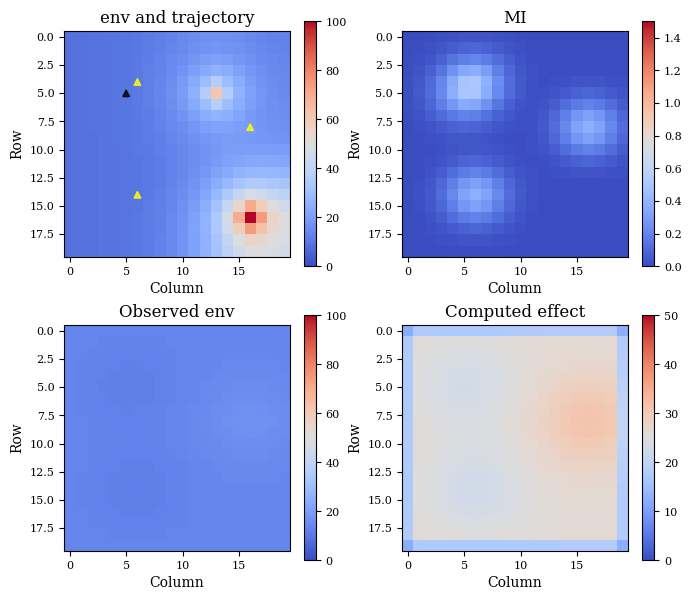

In [21]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(vehicle_team, Setting)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

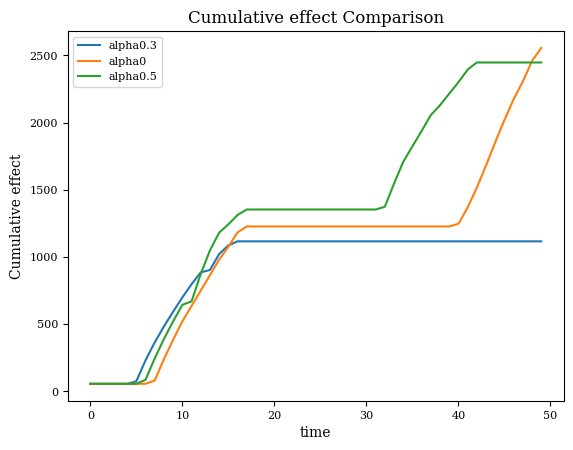

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# 从data.npz文件中加载数组
grid_x = 20
grid_y = 20
Strategy = "Nonmyopic_MI_Effect"
step = 8
Env = "Dynamic"
alpha = 0.0
adaptive = "Adaptive"
With_water = "WithWater"
spray = "Control"
effect_threshold = 25
team_size = 5
filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(grid_x, grid_y,Strategy,Env,alpha,adaptive,With_water,spray,team_size,effect_threshold,step)
data = np.load(filename)
effect_list_loaded1 = data['effect_list']

alpha = 0.3
filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(grid_x, grid_y,Strategy,Env,alpha,adaptive,With_water,spray,team_size,effect_threshold,step)
data2 = np.load(filename)
effect_list_loaded2 = data2['effect_list']

alpha = 0.5
filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(grid_x, grid_y,Strategy,Env,alpha,adaptive,With_water,spray,team_size,effect_threshold,step)
data3 = np.load(filename)
effect_list_loaded3 = data3['effect_list']

# alpha = 0.6
# filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(grid_x, grid_y,Strategy,Env,alpha,adaptive,With_water,spray,team_size,effect_threshold,step)
# data4 = np.load(filename)
# effect_list_loaded4 = data4['effect_list']

# alpha = 0.7
# filename = './outputs/x{}_y{}_{}_{}_alpha{}_{}_{}_{}_teamsize{}_threshold{}_step{}_result.npz'.format(grid_x, grid_y,Strategy,Env,alpha,adaptive,With_water,spray,team_size,effect_threshold,step)
# data5 = np.load(filename)
# effect_list_loaded5 = data5['effect_list']

# 计算每个数组的累计收益
cum_returns1 = np.cumsum(effect_list_loaded1)
cum_returns2 = np.cumsum(effect_list_loaded2)
cum_returns3 = np.cumsum(effect_list_loaded3)
# cum_returns4 = np.cumsum(effect_list_loaded4)
# cum_returns5 = np.cumsum(effect_list_loaded5)


# 创建一个新的Matplotlib图形
fig, ax = plt.subplots()

# 绘制第一个数组的累计收益曲线
ax.plot(cum_returns1, label='alpha0')

# 绘制第二个数组的累计收益曲线
ax.plot(cum_returns2, label='alpha0.3')

# 绘制第一个数组的累计收益曲线
ax.plot(cum_returns3, label='alpha0.5')

# # 绘制第二个数组的累计收益曲线
# ax.plot(cum_returns4, label='alpha0.6')

# # 绘制第一个数组的累计收益曲线
# ax.plot(cum_returns5, label='alpha0.7')

# 添加图例和标签
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('Cumulative effect')
ax.set_title('Cumulative effect Comparison')

# 显示图形
plt.show()

In [143]:
effect_list_loaded2

array([ 76.14644772,  72.8573859 ,  81.1164066 ,  85.55304801,
        86.80898959,  94.40014746, 106.23605831, 123.80705478,
       146.32392791, 180.53565041, 201.95914178, 211.52804753,
       212.57503327, 184.80755637, 169.84673339,  25.66858894,
         0.        ,   8.00661657,  40.12453129,  44.05106225,
        51.9477675 ,  59.5435215 ,  66.29471671,  71.92599457,
        86.78832102, 105.14637568, 111.99629799, 136.47956512,
       118.80297017, 113.40746463,  96.87790383,  97.28196253,
        15.74697567,   0.        ,   4.72739523,  29.99944259,
        39.72146684,  47.80110949,  46.46073927,  44.62889878,
        58.33971801,  82.40504195, 111.27776531,  98.99341334,
        83.54684025,  72.51494675,  71.55377622,  60.56582421,
        49.68822726,  10.38156463])

In [ ]:
from pypolo2.objectives.entropy import gaussian_entropy
from pypolo2.objectives.sprinkeffect import sprink_effect

candidate_states_list = []
last_state = x_train[-1,0:2]
for i in range(3):
    for j in range(3):
        c1 = last_state[0] -1 + i
        c2 = last_state[1] -1 + j
        if c1 < task_extent[0] or c1 > task_extent[1] or c2 < task_extent[2] or c2 > task_extent[3]:
            continue
        # if i == 1 and j == 1:
        #     continue
        candidate_states_list.append([c1, c2])
candidate_states = np.array(candidate_states_list)
#add demision
x, _ = model.get_data()
if x.shape[1] != candidate_states.shape[1]:
    model_input = np.zeros((candidate_states.shape[0],x.shape[1]))
    model_input[:,0:candidate_states.shape[1]] = candidate_states
    model_input[:,candidate_states.shape[1]:x.shape[1]] = model.time_stamp
else:
    model_input = candidate_states

print(model_input)
# first information object
# Evaluate candidates
prior_std, poste_std = model.prior_poste(model_input)

kernel.diag(model_input)

# print(poste_std)
# hprior = gaussian_entropy(prior_std.ravel())
# hposterior = gaussian_entropy(poste_std.ravel())
# mi = hprior - hposterior
# if np.any(mi < 0.0):
#     print(mi.ravel())
#     raise ValueError("Predictive MI < 0.0!")

# print(mi.shape)

# #second sprinkler effect
# allstate_list = []
# for i in range (task_extent[0],task_extent[1]+1):
#     for j in range (task_extent[2],task_extent[3]+1):
#         allstate_list.append([i, j, model.time_stamp])
# allstate = np.array(allstate_list)
# # print(allstate)
# mean, _ = model(allstate)
# print(mean[0])
# # print(model_input)
# sprinkeffect = sprink_effect(model_input,allstate,mean,task_extent).ravel()
# print(sprinkeffect)
# # Normalized scores
# # normed_mi = (mi - mi.min()) / mi.ptp()
# # normed_effect = (sprinkeffect - sprinkeffect.min()) / sprinkeffect.ptp()
# # # scores = normed_mi - normed_effect
# # scores = -normed_effect
# # # Append waypoint
# # sorted_indices = np.argsort(scores)
# # goal_states = candidate_states[sorted_indices[0:1]]
# # spray_flag = True

# # print(candidate_states[sorted_indices],sprinkeffect[sorted_indices])

In [ ]:
import numpy as np

def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    """Easy to understand but inefficient."""
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * dist_matrix)

def gaussian_kernel_vectorization(x1, x2, l=1.0, sigma_f=1.0):
    """More efficient approach."""
    dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

x = np.array([700, 800, 1029]).reshape(-1, 1)
print(gaussian_kernel_vectorization(x, x, l=500, sigma_f=10))

# Visualization

In [ ]:
from pypolo2.experiments import visualizer

In [ ]:
log = np.load(f"{save_dir}/log.npz")

In [ ]:
%matplotlib inline

In [ ]:
!pip install pyvirtualdisplay

In [ ]:
import pyvirtualdisplay

In [ ]:
d = pyvirtualdisplay.Display()
d.start() # Start Xvfb and set "DISPLAY" environment properly.

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from IPython import display

In [ ]:
display.clear_output(wait=True)
fig, ax = plt.subplots()
ax.imshow(mean.reshape(eval_grid))
display.display(plt.gcf())

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure();


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True);


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True);



In [ ]:
HTML(ani.to_jshtml())